In [1]:
import os
import pandas as pd
from pandas import DataFrame
import re
from pyecharts import Line, Geo, Bar, Pie, Page, ThemeRiver
from snownlp import SnowNLP
import jieba
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
fth = open('pyecharts_citys_supported.txt', 'r', encoding='utf-8').read() # pyecharts支持城市列表

# 过滤字符串只保留中文
def translate(str):
    line = str.strip()
    p2 = re.compile('[^\u4e00-\u9fa5]')   # 中文的编码范围是：\u4e00到\u9fa5
    zh = " ".join(p2.split(line)).strip()
    zh = ",".join(zh.split())
    str = re.sub("[A-Za-z0-9!！，%\[\],。]", "", zh)
    return str

In [3]:
# 下面是按照列属性读取的
def count_sentiment(csv_file):
    path = os.path.abspath(os.curdir)
    csv_file = path+ "\\" + csv_file + ".csv"
    csv_file = csv_file.replace('\\', '\\\\')
    d = pd.read_csv(csv_file, engine='python', encoding='utf-8')
    motion_list = []
    for i in d['content']:
        try:
            s = round(SnowNLP(i).sentiments, 2)
            motion_list.append(s)
        except TypeError:
            continue
    result = {}
    for i in set(motion_list):
        result[i] = motion_list.count(i)
    return result

In [4]:
def draw_sentiment_pic(csv_file):
    attr, val = [], []
    info = count_sentiment(csv_file)
    info = sorted(info.items(), key=lambda x: x[0], reverse=False)  # dict的排序方法
    for each in info[:-1]:
        attr.append(each[0])
        val.append(each[1])
    line = Line(csv_file+":影评情感分析")
    line.add("", attr, val, is_smooth=True, is_more_utils=True)
    line.render(csv_file+"_情感分析曲线图.html")

In [5]:
def word_cloud(csv_file, stopwords_path, pic_path):
    pic_name = csv_file+"_词云图.png"
    path = os.path.abspath(os.curdir)
    csv_file = path+ "\\" + csv_file + ".csv"
    csv_file = csv_file.replace('\\', '\\\\')
    d = pd.read_csv(csv_file, engine='python', encoding='utf-8')
    content = []
    for i in d['content']:
        try:
            i = translate(i)
        except AttributeError as e:
            continue
        else:
            content.append(i)
    comment_after_split = jieba.cut(str(content), cut_all=False)
    wl_space_split = " ".join(comment_after_split)
    backgroud_Image = plt.imread(pic_path)
    stopwords = STOPWORDS.copy()
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        for i in f.readlines():
            stopwords.add(i.strip('\n'))
        f.close()

    wc = WordCloud(width=1024, height=768, background_color='white',
                   mask=backgroud_Image, font_path="C:\simhei.ttf",
                   stopwords=stopwords, max_font_size=400,
                   random_state=50)
    wc.generate_from_text(wl_space_split)
    img_colors = ImageColorGenerator(backgroud_Image)
    wc.recolor(color_func=img_colors)
    plt.imshow(wc)
    plt.axis('off')  
    plt.show() 
    wc.to_file(pic_name)

In [6]:
def count_city(csv_file):
    path = os.path.abspath(os.curdir)
    csv_file = path+ "\\" + csv_file +".csv"
    csv_file = csv_file.replace('\\', '\\\\')
    
    d = pd.read_csv(csv_file, engine='python', encoding='utf-8')
    city = [translate(n) for n in d['city'].dropna()] # 清洗城市，将中文城市提取出来并删除标点符号等 
    
    # 这是从网上找的省份的名称，将其转换成列表的形式
    province = '湖南,湖北,广东,广西、河南、河北、山东、山西,江苏、浙江、江西、黑龙江、新疆,云南、贵州、福建、吉林、安徽,四川、西藏、宁夏、辽宁、青海、甘肃、陕西,内蒙古、台湾,海南'
    province = province.replace('、',',').split(',')
    rep_province = "|".join(province) # re.sub中城市替换的条件
    
    All_city = jieba.cut("".join(city)) # 分词，将省份和市级地名分开，当然有一些如吉林长春之类没有很好的分开，因此我们需要用re.sub（）来将之中的省份去除掉
    final_city= []
    for a_city in All_city:
        a_city_sub = re.sub(rep_province,"",a_city) # 对每一个单元使用sub方法，如果有省份的名称，就将他替换为“”（空）
        if a_city_sub == "": # 判断，如果为空，跳过
            continue
        elif a_city_sub in fth: # 因为所有的省份都被排除掉了，便可以直接判断城市在不在列表之中，如果在，final_city便增加
            final_city.append(a_city_sub)
        else: # 不在fth中的城市，跳过
            continue
            
    result = {}
    print("城市总数量为：",len(final_city))
    for i in set(final_city):
        result[i] = final_city.count(i)
    return result

In [7]:
def draw_citys_pic(csv_file):
    page = Page(csv_file+":评论城市分析")
    info = count_city(csv_file)
    geo = Geo("","小本聪原创",title_pos="center", width=1200,height=600, background_color='#404a59', title_color="#fff")
    while True:   # 二次筛选，和pyecharts支持的城市库进行匹配，如果报错则删除该城市对应的统计
        try:
            attr, val = geo.cast(info)
            geo.add("", attr, val, visual_range=[0, 300], visual_text_color="#fff", is_geo_effect_show=False,
                    is_piecewise=True, visual_split_number=6, symbol_size=15, is_visualmap=True)
        except ValueError as e:
            e = str(e)
            e = e.split("No coordinate is specified for ")[1]  # 获取不支持的城市名称
            info.pop(e)
        else:
            break
    info = sorted(info.items(), key=lambda x: x[1], reverse=False)  # list排序
    print(info)
    info = dict(info)   # list转dict
    print(info)
    attr, val = [], []
    for key in info:
        attr.append(key)
        val.append(info[key])


    geo1 = Geo("", "评论城市分布", title_pos="center", width=1200, height=600,
              background_color='#404a59', title_color="#fff")
    geo1.add("", attr, val, visual_range=[0, 300], visual_text_color="#fff", is_geo_effect_show=False,
            is_piecewise=True, visual_split_number=10, symbol_size=15, is_visualmap=True, is_more_utils=True)
    # geo1.render(csv_file + "_城市dotmap.html")
    page.add_chart(geo1)
    geo2 = Geo("", "评论来源热力图",title_pos="center", width=1200,height=600, background_color='#404a59', title_color="#fff",)
    geo2.add("", attr, val, type="heatmap", is_visualmap=True, visual_range=[0, 50],visual_text_color='#fff', is_more_utils=True)
    # geo2.render(csv_file+"_城市heatmap.html")  # 取CSV文件名的前8位数
    page.add_chart(geo2)
    bar = Bar("", "评论来源排行", title_pos="center", width=1200, height=600 )
    bar.add("", attr, val, is_visualmap=True, visual_range=[0, 100], visual_text_color='#fff',mark_point=["average"],mark_line=["average"],
            is_more_utils=True, is_label_show=True, is_datazoom_show=True, xaxis_rotate=45)
    bar.render(csv_file+"_城市评论bar.html")  # 取CSV文件名的前8位数
    page.add_chart(bar)
    pie = Pie("", "评论来源饼图", title_pos="right", width=1200, height=600)
    pie.add("", attr, val, radius=[20, 50], label_text_color=None, is_label_show=True, legend_orient='vertical', is_more_utils=True, legend_pos='left')
    pie.render(csv_file + "_城市评论Pie.html")  # 取CSV文件名的前8位数
    page.add_chart(pie)
    page.render(csv_file + "_城市评论分析汇总.html")

In [8]:
def score_draw(csv_file):
    page = Page(csv_file+":评论等级分析")
    score, date, val, score_list = [], [], [], []
    result = {}
    path = os.path.abspath(os.curdir)
    csv_file = path + "\\" + csv_file + ".csv"
    csv_file = csv_file.replace('\\', '\\\\')
    d = pd.read_csv(csv_file, engine='python', encoding='utf-8')[['score', 'date']].dropna()  # 读取CSV转为dataframe格式，并丢弃评论为空的记录
    for indexs in d.index:  # 一种遍历df行的方法（下面还有第二种，iterrows）
        score_list.append(tuple(d.loc[indexs].values[:])) # 目前只找到转换为tuple然后统计相同元素个数的方法
    print("有效评分总数量为：",len(score_list), " 条")
    for i in set(list(score_list)):
        result[i] = score_list.count(i)  # dict类型
    info = []
    for key in result:
        score= key[0]
        date = key[1]
        val = result[key]
        info.append([score, date, val])
    info_new = DataFrame(info)  # 将字典转换成为数据框
    info_new.columns = ['score', 'date', 'votes']
    info_new.sort_values('date', inplace=True)    # 按日期升序排列df，便于找最早date和最晚data，方便后面插值
    print("first df", info_new)
    # 以下代码用于插入空缺的数据，每个日期的评分类型应该有5中，依次遍历判断是否存在，若不存在则往新的df中插入新数值
    mark = 0
    creat_df = pd.DataFrame(columns = ['score', 'date', 'votes']) # 创建空的dataframe
    for i in list(info_new['date']):
        location = info_new[(info_new.date==i)&(info_new.score=="力荐")].index.tolist()
        if location == []:
            creat_df.loc[mark] = ["力荐", i, 0]
            mark += 1
        location = info_new[(info_new.date==i)&(info_new.score=="推荐")].index.tolist()
        if location == []:
            creat_df.loc[mark] = ["推荐", i, 0]
            mark += 1
        location = info_new[(info_new.date==i)&(info_new.score=="还行")].index.tolist()
        if location == []:
            creat_df.loc[mark] = ["还行", i, 0]
            mark += 1
        location = info_new[(info_new.date==i)&(info_new.score=="较差")].index.tolist()
        if location == []:
            creat_df.loc[mark] = ["较差", i, 0]
            mark += 1
        location = info_new[(info_new.date==i)&(info_new.score=="很差")].index.tolist()
        if location == []:
            creat_df.loc[mark] = ["很差", i, 0]
            mark += 1
    info_new = info_new.append(creat_df.drop_duplicates(), ignore_index=True)
    score_list = []
    info_new.sort_values('date', inplace=True)    # 按日期升序排列df，便于找最早date和最晚data，方便后面插值
    print(info_new)
    for index, row in info_new.iterrows():   # 第二种遍历df的方法
        score_list.append([row['date'], row['votes'], row['score']])
    tr = ThemeRiver()
    tr.add(['力荐', '推荐', '还行', '较差', '很差'], score_list, is_label_show=True, is_more_utils=True)
    page.add_chart(tr)

    attr, v1, v2, v3, v4, v5 = [], [], [], [], [], []
    attr = list(sorted(set(info_new['date'])))
    bar = Bar()
    for i in attr:
        v1.append(int(info_new[(info_new['date']==i)&(info_new['score']=="力荐")]['votes']))
        v2.append(int(info_new[(info_new['date']==i)&(info_new['score']=="推荐")]['votes']))
        v3.append(int(info_new[(info_new['date']==i)&(info_new['score']=="还行")]['votes']))
        v4.append(int(info_new[(info_new['date']==i)&(info_new['score']=="较差")]['votes']))
        v5.append(int(info_new[(info_new['date']==i)&(info_new['score']=="很差")]['votes']))
    bar.add("力荐", attr, v1, is_stack=True)
    bar.add("推荐", attr, v2, is_stack=True)
    bar.add("还行", attr, v3, is_stack=True)
    bar.add("较差", attr, v4, is_stack=True)
    bar.add("很差", attr, v5, is_stack=True, is_convert=True, mark_line=["average"], is_more_utils=True)
    page.add_chart(bar)

    line = Line()
    line.add("力荐", attr, v1, is_stack=True)
    line.add("推荐", attr, v2, is_stack=True)
    line.add("还行", attr, v3, is_stack=True)
    line.add("较差", attr, v4, is_stack=True)
    line.add("很差", attr, v5, is_stack=True, is_convert=False, mark_line=["average"], is_more_utils=True)
    page.add_chart(line)

    page.render(csv_file[:-4] + "_日投票量分析汇总.html")


def main(csv_file, stopwords_path, pic_path):
    draw_sentiment_pic(csv_file)
    draw_citys_pic(csv_file)
    score_draw(csv_file)
    word_cloud(csv_file,stopwords_path, pic_path)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\POLETO~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\POLETO~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.734 seconds.
DEBUG:jieba:Loading model cost 0.734 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


城市总数量为： 75
[('重庆', 1), ('西安', 2), ('武汉', 2), ('广州', 2), ('深圳', 2), ('杭州', 2), ('成都', 2), ('福州', 2), ('南京', 5), ('上海', 16), ('北京', 39)]
{'重庆': 1, '西安': 2, '武汉': 2, '广州': 2, '深圳': 2, '杭州': 2, '成都': 2, '福州': 2, '南京': 5, '上海': 16, '北京': 39}
有效评分总数量为： 98  条
first df    score        date  votes
6     较差  2019-01-12      2
0     推荐  2019-01-20      5
12    较差  2019-01-20      2
11    力荐  2019-01-20      6
26    力荐  2019-01-22      2
13    推荐  2019-01-27      2
25    很差  2019-01-28      1
24    较差  2019-01-28      2
14    还行  2019-01-28      1
3     推荐  2019-01-28      4
9     推荐  2019-01-29      1
2     力荐  2019-01-29      4
17    还行  2019-01-29      2
18    较差  2019-01-29      2
10    推荐  2019-02-02      2
15    推荐  2019-02-04      3
1     很差  2019-02-04      2
16    还行  2019-02-05      5
8     力荐  2019-02-05      2
21    较差  2019-02-05     11
23    很差  2019-02-05     13
4     推荐  2019-02-05      5
5     较差  2019-02-06      5
22    力荐  2019-02-06      2
7     很差  2019-02-06      2
28    很差  

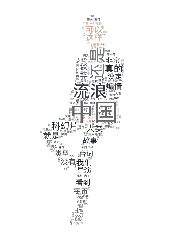

In [9]:
main("流浪地球", "stopwords.txt", "胡歌.jpg" )